# Check: Nominal GDP in USDbn

In [1]:
import sqlalchemy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import qstools as qs
import math

import warnings
warnings.simplefilter('ignore')

Alternative: C:\ProgramData\Anaconda3\lib\site-packages\qstools\__init__.py win32


In [2]:
dbi = qs.interfaces.DbIndicatorsInterface(username="rsueppel", host="qs-db.cpdsgdta9z0z.eu-west-2.rds.amazonaws.com",
                                          password="l3oT7^WerjY#O!9EGqvL", database="qs_jpm_point_time")
cids = ['AUD', 'BRL', 'CAD', 'CHF', 'CLP', 'CNY', 'COP', 'EUR', 'GBP', 'HUF', 'IDR', 'INR', 'JPY', 
        'KRW', 'MYR', 'MXN', 'NOK', 'NZD', 'PEN', 'PHP', 'PLN', 'RON', 'RUB', 'SEK', 'SGD', 'THB', 
        'TRY', 'TWD', 'USD', 'ZAR']
cats = ['NGDPUSDBN']
dfq = dbi.get_series_values(category=cats, cross_section=cids, frequency="q")  # import grade 1 vintages

In [3]:
dfq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331069 entries, 0 to 331068
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cross_section     331069 non-null  object 
 1   category_code     331069 non-null  object 
 2   adjustment        331069 non-null  object 
 3   transformation    0 non-null       object 
 4   release_date      331069 non-null  object 
 5   observation_date  331069 non-null  object 
 6   value             331069 non-null  float64
 7   grading           331069 non-null  object 
dtypes: float64(1), object(7)
memory usage: 20.2+ MB


## Data availability

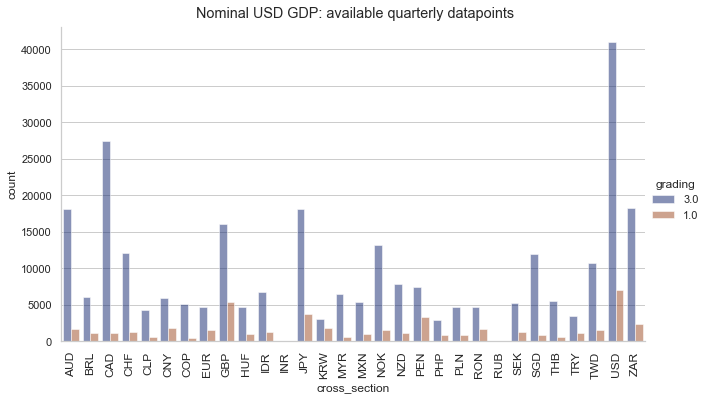

In [4]:
sns.set_theme(style='whitegrid')
g = sns.catplot(data=dfq, kind='count', order=cids, x='cross_section', hue='grading',
                palette='dark', aspect=1.8, alpha=0.5)
g.set_xticklabels(rotation=90, size=12)
g.fig.suptitle('Nominal USD GDP: available quarterly datapoints', y=1.02)
plt.show()

In [6]:
def countmap(cat, start_year, figsize=(12, 12), trueVin = False):
    dfx = dfq[dfq['category_code']==cat]
    if trueVin:
        dfx = dfx[dfx['grading'].isin(['1', '1.0', '2.2'])]
    xids = np.sort(dfx['cross_section'].unique())
    dfx.loc[:, 'year'] = pd.DatetimeIndex(dfx.loc[:,'release_date']).year
    dfx = dfx[dfx.year >= start_year]

    dfxx = pd.DataFrame(columns=dfx.columns)
    for cid in xids:
        dfc = dfx.query('cross_section == @cid').reset_index(drop=True)
        releases = dfc[["year", "release_date"]].groupby("year")["release_date"].max().values.tolist()  # use panda series!
        dfcx = dfc[dfc['release_date'].isin(releases)]
        dfxx = dfxx.append(dfcx)

    count_matrix = pd.crosstab(dfxx["year"], dfxx["cross_section"])  # per default crosstab counts rows
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(count_matrix, annot=True, fmt="d",
                    cmap="YlGnBu", cbar=False, linewidths=.5)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(cat + ': Vintage lengths at last available release in year', y = 1.1, fontsize=14)

<function matplotlib.pyplot.show(*args, **kw)>

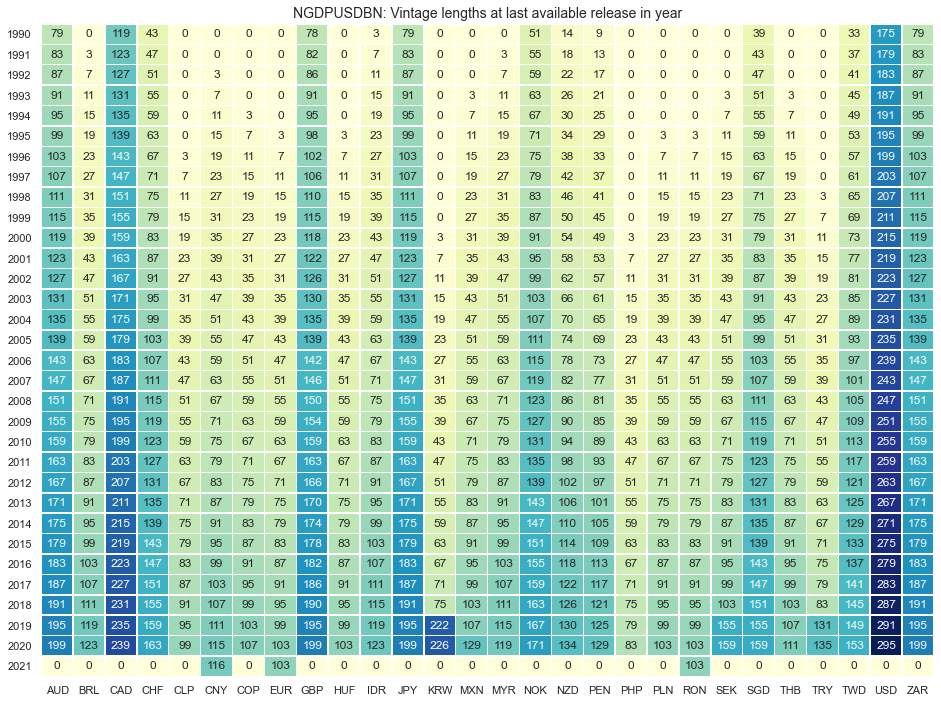

In [7]:
countmap('NGDPUSDBN', 1990, (16, 12))
plt.show

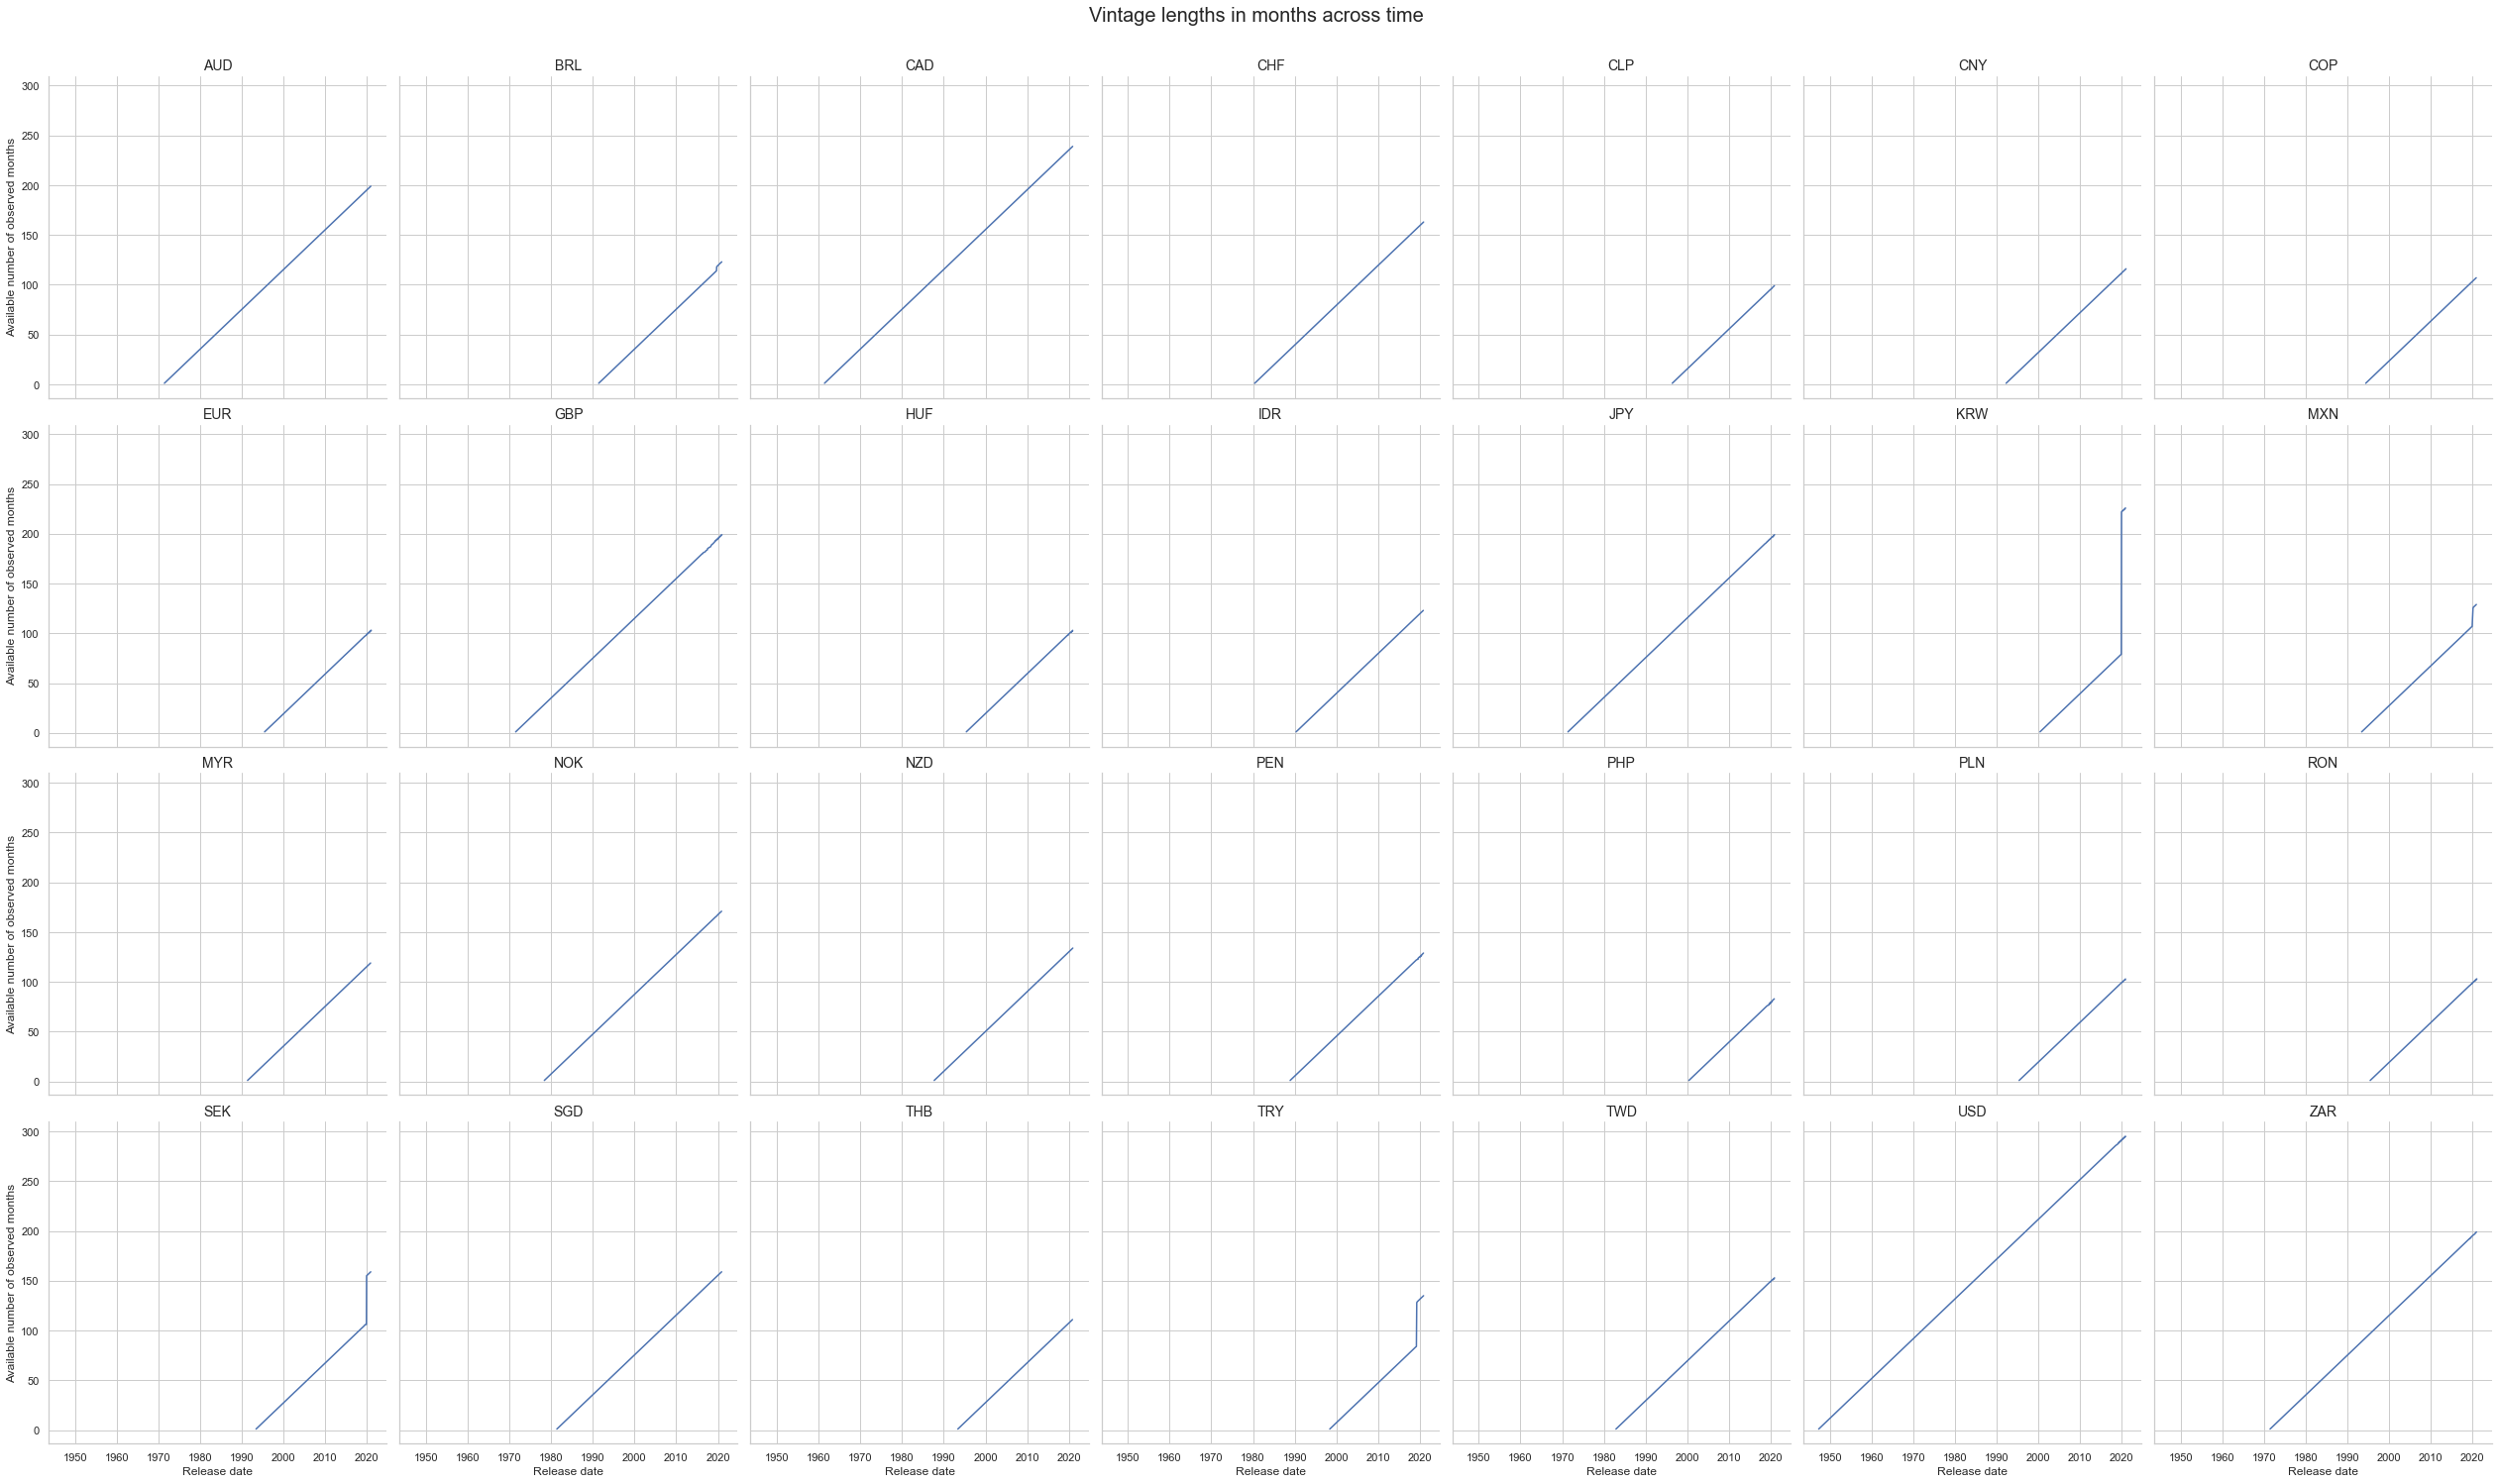

In [8]:
cols = ['cross_section', 'release_date', 'observation_date']
dfq_x = dfq.loc[:, cols].groupby(['cross_section', 'release_date']).agg('count')
dfq_x.reset_index(inplace=True)
f = sns.relplot(x='release_date', y = 'observation_date', data=dfq_x, kind='line', col='cross_section', col_wrap=7)
(f.set_axis_labels("Release date", "Available number of observed months")
  .set_titles("{col_name}", size=14)
  .fig.suptitle('Vintage lengths in months across time', y = 1.03, fontsize=20))
plt.show()

## Revision graphics

<function matplotlib.pyplot.show(*args, **kw)>

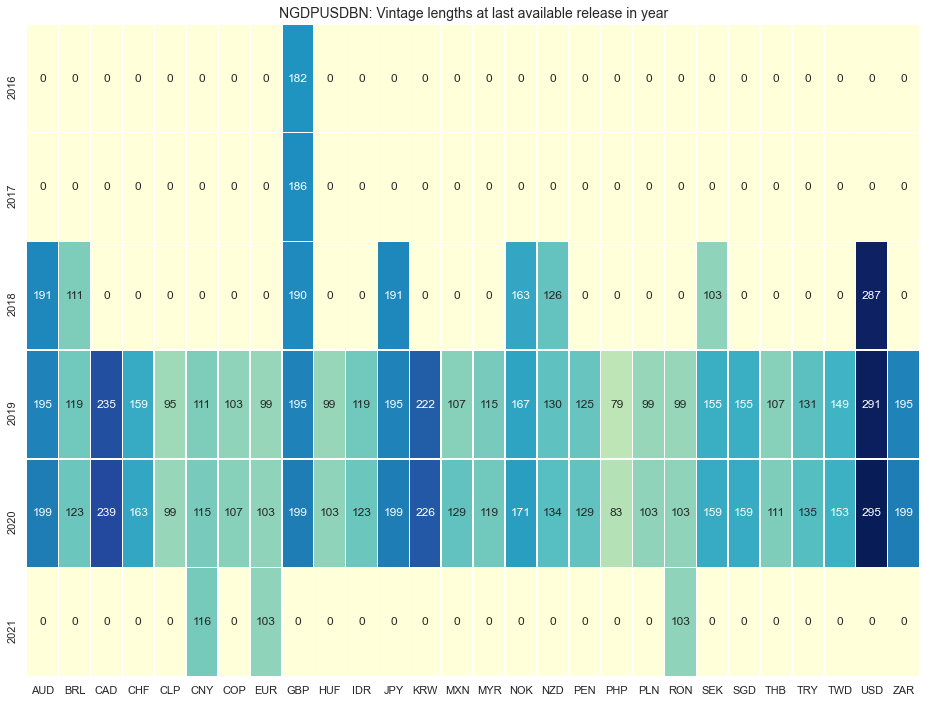

In [11]:
countmap('NGDPUSDBN', 1990, (16, 12), trueVin=True)
plt.show

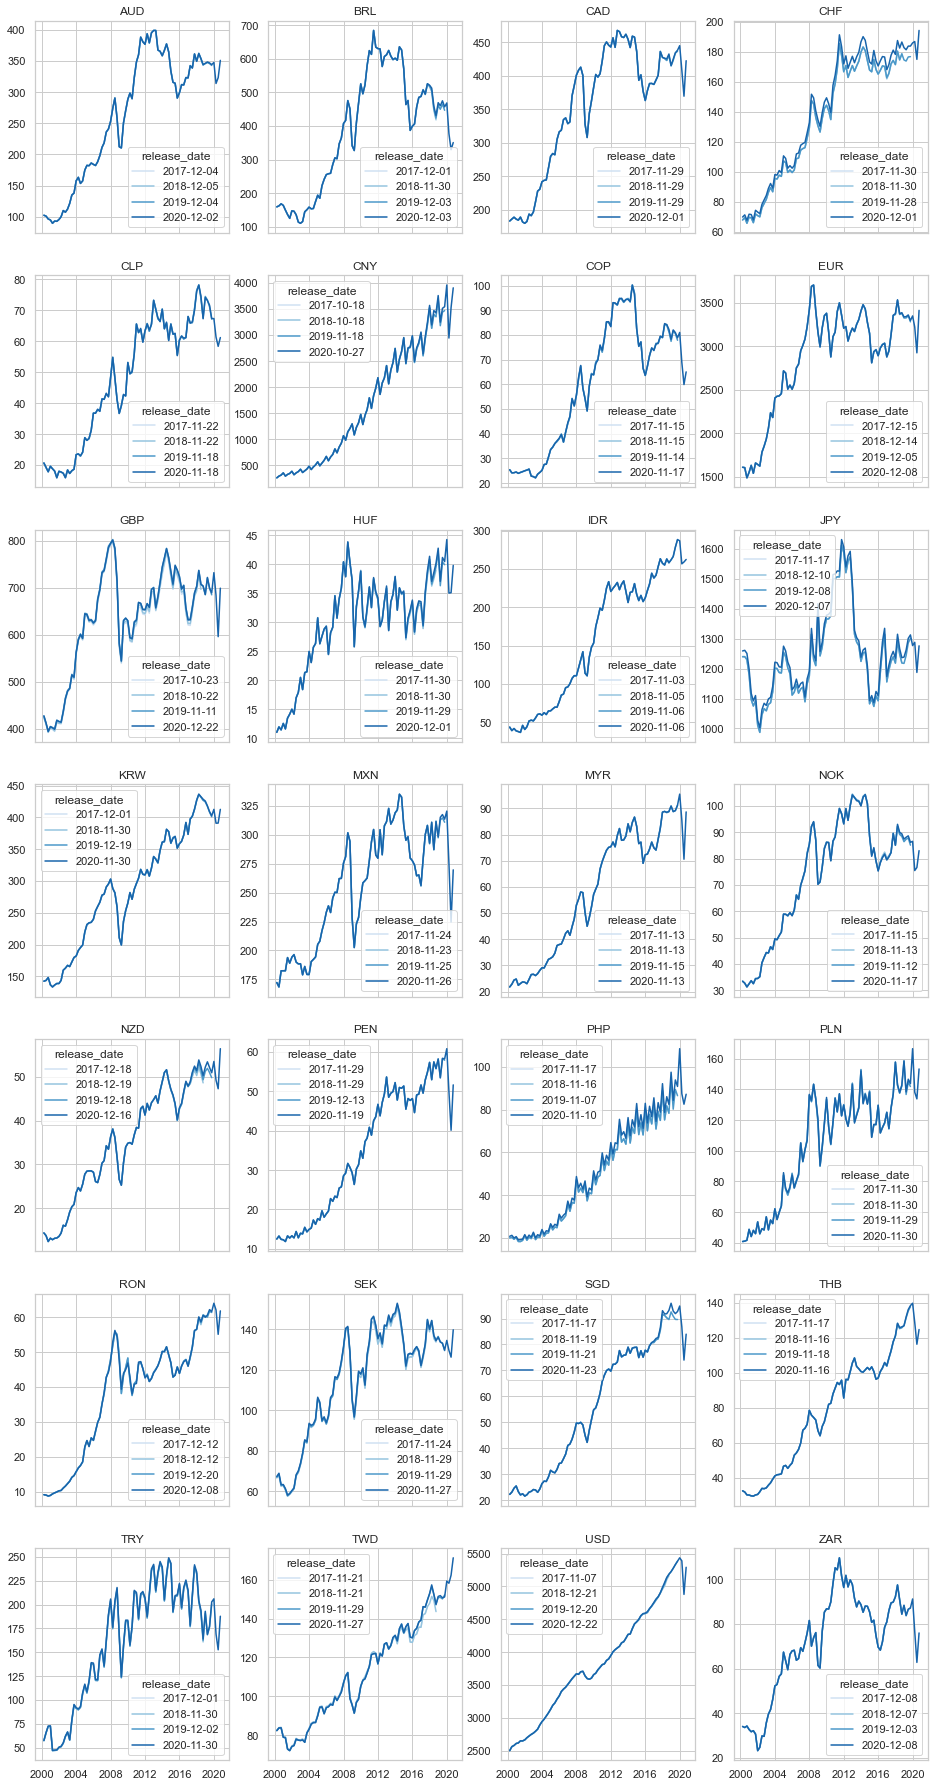

In [12]:
pots = ['2020-12-31', '2019-12-31', '2018-12-31', '2017-12-31']
dfq_x = dfq[dfq['observation_date'] > pd.to_datetime('2000-01-01')]  # reduce relevant history
xids = np.sort(dfq_x['cross_section'].unique())

sns.set_style('whitegrid')
ncolumns = 4
colors = sns.color_palette("Blues", len(pots))
fig, axes = plt.subplots(nrows=math.ceil(len(xids)/ncolumns), ncols=ncolumns, sharex=True, figsize=(16, 32))

for i in range(len(xids)):
    cid = xids[i]
    dfq_xc = dfq_x.query('cross_section == @cid')
    releases = dfq_xc['release_date'].unique()
    selected_releases = [None] * len(pots)
    for p in range(len(pots)):  # get releases nearest and before chosen ones
        release = releases[(releases <= pd.to_datetime(pots[p]))].max()
        selected_releases[p] = release
    dfq_xcx = dfq_xc[dfq_xc['release_date'].isin(selected_releases)]
    axe = axes[math.floor(i / ncolumns), (i % ncolumns)]
    sns.lineplot(data=dfq_xcx,  x="observation_date", y="value", 
                 hue="release_date", palette=colors, ax=axe)
    axe.set(title=cid, ylabel="", xlabel="")
    
plt.show()

## Latest vintage check

In [13]:
indices = []
for cid in dfq.cross_section.unique():  # extract dataframe with last release_dates for each ticker only
    dfq_x = dfq[dfq['cross_section'] == cid]
    dfq_xx = dfq_x[dfq_x['release_date'] == dfq_x['release_date'].max()]
    indices = indices + dfq_xx.index.tolist()
dfq_lv = dfq.iloc[indices, :]  # extract last vintage

Plausibility of latest annualized values

   cross_section         value
0            AUD   1335.365071
1            BRL   1525.478445
2            CAD   1644.752871
3            CHF    741.773335
4            CLP    248.242546
5            CNY  14908.579347
6            COP    274.885245
7            EUR  12911.946531
8            GBP   2713.159941
9            HUF    154.178115
10           IDR   1065.180164
11           JPY   5027.856423
12           KRW   1606.779067
13           MXN   1090.026768
14           MYR    340.107569
15           NOK    321.541993
16           NZD    206.607601
17           PEN    202.476534
18           PHP    365.600142
19           PLN    591.915502
20           RON    244.339244
21           SEK    530.428358
22           SGD    339.537619
23           THB    509.312496
24           TRY    715.763222
25           TWD    651.300755
26           USD  20999.724750
27           ZAR    306.592830


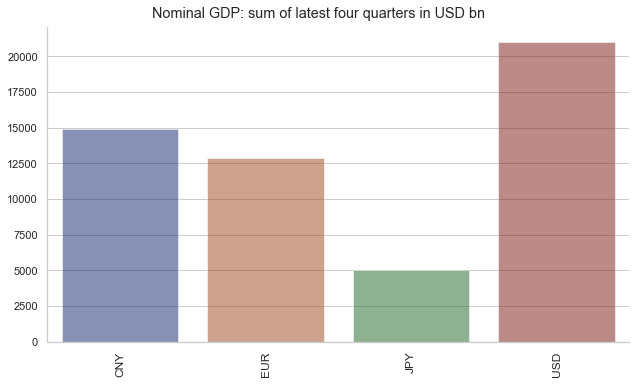

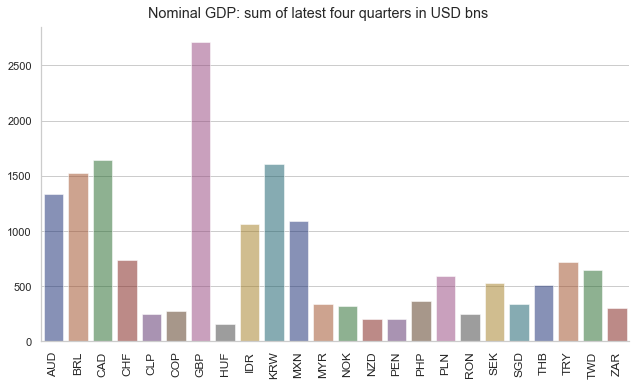

In [14]:
dfq_vl_w = dfq_lv.pivot(index='observation_date', columns='cross_section', values='value')

sns.set_theme(style='whitegrid')
dfq_chart = pd.melt(dfq_vl_w.rolling(4).sum().ffill().tail(1))
print(dfq_chart)
index_big = dfq_chart['cross_section'].isin(['USD', 'EUR', 'CNY', 'JPY'])

g = sns.catplot(data=dfq_chart[index_big], kind='bar', x='cross_section', y='value', palette='dark', aspect=1.8, alpha=0.5)
g.set_xticklabels(rotation=90, size=12)
g.fig.suptitle('Nominal GDP: sum of latest four quarters in USD bn', y=1.02)
plt.xlabel('')
plt.ylabel('')
plt.show()

g = sns.catplot(data=dfq_chart[~index_big], kind='bar', x='cross_section', y='value', palette='dark', aspect=1.8, alpha=0.5)
g.set_xticklabels(rotation=90, size=12)
g.fig.suptitle('Nominal GDP: sum of latest four quarters in USD bns', y=1.02)
plt.xlabel('')
plt.ylabel('')
plt.show()